# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier

import joblib

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
plt.rcParams['figure.figsize'] = (30,30)

import warnings
warnings.filterwarnings("ignore")

# Define path for saving files
import os
path=r'C:\Users\songying7\Desktop\Projects\atptour_analysis\index_csv'

# Data Preparation

In [7]:
# Prepare both csv for matches and clustered players
df_match = pd.read_csv('index_csv/clean_df_v3.0.csv')
df_cluster = pd.read_csv('index_csv/player_with_labels.csv')

## Case Study: Wimbledon 2019 Final

In [9]:
df_wim_2019_final = df_match[df_match['match_id'] == '2019-540-MS001-10-1-d643-f324']

# Remove case study from dataset
df_match = df_match[df_match['match_id'] != '2019-540-MS001-10-1-d643-f324']
df_match.reset_index(drop = True, inplace = True)

## Mapping Cluster Group Values & Imputing Missing Data

In [10]:
# Map clustered group onto matches data
slug_list = list(df_cluster['slug'])
df = df_match
df['group'] = np.nan
for i in range(0,len(df_match)):
    if df_match['slug'][i] in slug_list:
        df['group'][i] = df_cluster[df_cluster['slug'] == df_match['slug'][i]]['group'].values[0]
    else:
        df['group'][i] = np.nan

# First run takes 2 minutes

In [11]:
# Impute for missing values with weighted probabilities of each clustered group
choice = [0,1]
prob = df[df['group'].isna() == False]['group'].value_counts(normalize=True).sort_index()
df['group'].fillna(np.random.choice(choice, 1, p= prob)[0], inplace = True)

In [14]:
df.to_csv(os.path.join(path,r'merged_df.csv'), index = False)

# Initial Data Analysis

In [15]:
df = pd.read_csv('index_csv/merged_df.csv')

In [16]:
# Court distribution
df['surface'].value_counts()

Hard      95020
Clay      60534
Grass     19272
Carpet     9490
Name: surface, dtype: int64

## Performance of Player Groups on 3 Different Surfaces

In [17]:
# Hard court statistics per cluster group
hard_df = df[df.surface == 'Hard']
val_count_group_hard_group0 = hard_df[hard_df.group == 1.0]['winner'].value_counts()
val_count_group_hard_group1 = hard_df[hard_df.group == 0.0]['winner'].value_counts()

# Clay court statistics per cluster group
clay_df = df[df.surface == 'Clay']
val_count_group_clay_group0 = clay_df[clay_df.group == 0.0]['winner'].value_counts()
val_count_group_clay_group1 = clay_df[clay_df.group == 1.0]['winner'].value_counts()

# Grass court statistics per cluster group
grass_df = df[df.surface == 'Grass']
val_count_group_grass_group0 = grass_df[grass_df.group == 0.0]['winner'].value_counts()
val_count_group_grass_group1 = grass_df[grass_df.group == 1.0]['winner'].value_counts()

In [18]:
# Base win rate per player group per surface

base_win_rate_per_surface = pd.DataFrame(columns = ['player_group', 'clay', 'hard', 'grass'])

base_win_rate_per_surface = base_win_rate_per_surface.append(pd.Series(), ignore_index=True)
base_win_rate_per_surface = base_win_rate_per_surface.append(pd.Series(), ignore_index=True)
base_win_rate_per_surface['player_group'] = ['group0', 'group1']

base_win_rate_per_surface['hard'] = [val_count_group_hard_group0.loc[1.0] / val_count_group_hard_group0.sum(),
                                     val_count_group_hard_group1.loc[1.0] / val_count_group_hard_group1.sum()]

base_win_rate_per_surface['clay'] = [val_count_group_clay_group0.loc[1.0] / val_count_group_clay_group0.sum(),
                                     val_count_group_clay_group1.loc[1.0] / val_count_group_clay_group1.sum()]

base_win_rate_per_surface['grass'] = [val_count_group_grass_group0.loc[1.0] / val_count_group_grass_group0.sum(),
                                     val_count_group_grass_group1.loc[1.0] / val_count_group_grass_group1.sum()]

print("Average base win rate on each surface by each player group \n \
Group0 = Players with a balanced service-return game \n \
Group1 = Players with a service-dominant game")

base_win_rate_per_surface

Average base win rate on each surface by each player group 
 Group0 = Players with a balanced service-return game 
 Group1 = Players with a service-dominant game


,player_group,clay,hard,grass
0,group0,0.502646,0.518036,0.491106
1,group1,0.479294,0.495843,0.533565


The result shown above is consistent:

Clay courts are played the slowest, which reduces the effectiveness of service-dominant players; Group 1 players (Service-dominant players) perform the worst on clay surfaces.

Hard court plays faster than clay but slower than grass, which supposedly is the most balanced court available, hence a balanced service-return game is required to excel on this surface; Evidently, Group 0 players (Balanced players) perform the best on hard surfaces. 

Grass court is the fastest surface available on tour, hence it heavily benefits service-dominant players; As shown in the result, Group 1 players has the highest base win rate of any combination, with a 53.4 % chance of winning a match on grass courts, significantly higher than their performance on clay and hard courts, which both are more likely to result in losses, with only 47.9 % chance of winning a match on clay court and 49.6 % on hard court.

## Service & Return Performance Required to Win a Match

In [19]:
# Average Service Performance Required to Win A Match On Different Surfaces

print("Average service point % required to win:")

print(f"On a clay court match: {round(clay_df[clay_df['winner'] == 1.0]['service_points_won_%'].mean() * 100,2)} %.")

print(f"On a hard court match: {round(hard_df[hard_df['winner'] == 1.0]['service_points_won_%'].mean() * 100,2)} %.")

print(f"On a grass court match: {round(grass_df[grass_df['winner'] == 1.0]['service_points_won_%'].mean() * 100,2)} %.")

print("\n")
      
# Average Return Performance Required to Win A Match On Different Surfaces

print("Average return point % required to win:")

print(f"On a clay court match: {round(clay_df[clay_df['winner'] == 1.0]['return_points_won_%'].mean() * 100,2)} %.")

print(f"On a hard court match: {round(hard_df[hard_df['winner'] == 1.0]['return_points_won_%'].mean() * 100,2)} %.")

print(f"On a grass court match: {round(grass_df[grass_df['winner'] == 1.0]['return_points_won_%'].mean() * 100,2)} %.")

Average service point % required to win:
On a clay court match: 66.45 %.
On a hard court match: 68.71 %.
On a grass court match: 70.31 %.


Average return point % required to win:
On a clay court match: 45.3 %.
On a hard court match: 42.73 %.
On a grass court match: 40.69 %.


## Break Points

In [20]:
print(f"Number of players winning the match without having any break point chance: \
{df[df['any_break_points_chance?'] == 0.0]['winner'].value_counts().sum() - df[df['any_break_points_chance?'] == 0.0]['winner'].value_counts().loc[0.0]}")

print("")
print("Average break points required to win a match:")
print(f"On All Courts: {round(df[df['winner'] == 1.0]['break_points_converted'].mean(), 2)}")
print(f"On Clay Courts: {round(clay_df[clay_df['winner'] == 1.0]['break_points_converted'].mean(), 2)}")
print(f"On Hard Courts: {round(hard_df[hard_df['winner'] == 1.0]['break_points_converted'].mean(), 2)}")
print(f"On Grass Courts: {round(grass_df[grass_df['winner'] == 1.0]['break_points_converted'].mean(), 2)}")

Number of players winning the match without having any break point chance: 0

Average break points required to win a match:
On All Courts: 3.95
On Clay Courts: 4.34
On Hard Courts: 3.81
On Grass Courts: 3.73


## Winning a Match with Total Point Deficit

In [30]:
winner_df = df[df['winner'] == 1.0]
print(f"Total matches included in dataset: {winner_df.shape[0]}")
print("")
print(f"Total winners winning a match with less points won than opponent: {winner_df[winner_df['total_points_won_%'] < 0.5].shape[0]}")
print("")
print(f"Percentage of winner with a total point deficit: {round(winner_df[winner_df['total_points_won_%'] < 0.5].shape[0] / winner_df.shape[0] * 100, 2)} %")    

Total matches included in dataset: 92158

Total winners winning a match with less points won than opponent: 4218

Percentage of winner with a total point deficit: 4.58 %


# Feature Importance Analysis

In [31]:
# Reload dataframe
df = pd.read_csv('index_csv/merged_df.csv')

## Preliminary Data Cleaning

In [32]:
df['total_return_points_played_%'] = np.nan

for i in range(0, len(df)):
    df['total_return_points_played_%'][i] = df['return_points_total'][i] / df['total_points_total'][i]

In [33]:
df_continuous_target = df['total_points_won_%']

to_drop = ['match_id', 'conditions', 'year', 'tourney_slug', 'slug', 'aces_df_ratio',
          'first_serves_in', 'first_serves_total', 'first_serve_points_won', 'first_serve_points_total',
          'second_serve_points_won', 'second_serve_points_total', 
           'break_points_saved', 'service_games_played', 'return_games_played', 'first_serve_return_won',
          'first_serve_return_total', 'second_serve_return_won', 'second_serve_return_total',
          'break_points_converted', 'service_points_won', 'return_points_won', 
           'total_points_won', 'total_points_won_%',
           
          'serve_rating', 'return_rating', 'service_points_total', 'aces', 'return_points_total', 'total_points_total',
          
          'service_points_won_%', 'return_points_won_%', 'serve_return_rating_ratio',
          
          'diff_in_return_points_played', 'any_break_points_chance?', 'faced_break_points?',
          
          'break_points_serve_total', 'group', 'double_faults', 'match_duration',
          
          'serve_return_points_won_ratio', 'aces_per_min']

df.drop(columns = to_drop, axis = 1, inplace= True)

In [34]:
df.to_csv(os.path.join(path,r'merged_df_v1.1.csv'), index = False)

## Multicollinearity

### Correlation Matrix (Visual Inspection)

In [35]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,first_serves_in_%,first_serves_points_won_%,second_serves_points_won_%,break_point_save_%,first_serves_return_points_won_%,second_serves_return_points_won_%,break_points_return_total,break_point_convert_%,diff_in_first_serves_in_%,winner,total_return_points_played_%
first_serves_in_%,1,-0.0790399,0.0695833,0.0345145,0.0607624,0.0556801,0.0503825,0.0207009,-0.00736759,0.106087,0.0611436
first_serves_points_won_%,-0.0790399,1,0.33118,0.0475061,0.160899,0.198631,0.151819,0.091578,0.0100647,0.522402,0.312365
second_serves_points_won_%,0.0695833,0.33118,1,0.0291032,0.195847,0.218608,0.157173,0.105651,-0.0120084,0.481118,0.311727
break_point_save_%,0.0345145,0.0475061,0.0291032,1,-0.0366239,-0.0265148,0.0214964,-0.0278293,-0.018828,0.0708372,-0.273756
first_serves_return_points_won_%,0.0607624,0.160899,0.195847,-0.0366239,1,0.327248,0.530045,0.36411,-0.00903649,0.516248,0.308551
second_serves_return_points_won_%,0.0556801,0.198631,0.218608,-0.0265148,0.327248,1,0.4655,0.331809,0.0119951,0.479797,0.310617
break_points_return_total,0.0503825,0.151819,0.157173,0.0214964,0.530045,0.4655,1,0.0315934,-0.0327306,0.436226,0.418815
break_point_convert_%,0.0207009,0.091578,0.105651,-0.0278293,0.36411,0.331809,0.0315934,1,-0.00679945,0.313983,-0.108014
diff_in_first_serves_in_%,-0.00736759,0.0100647,-0.0120084,-0.018828,-0.00903649,0.0119951,-0.0327306,-0.00679945,1,4.86827e-17,6.48804e-07
winner,0.106087,0.522402,0.481118,0.0708372,0.516248,0.479797,0.436226,0.313983,4.86827e-17,1,0.260332


### Variance Inflation Factor

In [36]:
surface_dummies = df['surface'].str.get_dummies()
df_vif = df.join(surface_dummies)
df_vif.drop('surface', axis = 1, inplace = True)

In [37]:
vif = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
list(zip(df_vif.columns, vif))

[('first_serves_in_%', 1.058443997192937),
 ('first_serves_points_won_%', 1.6710574944786194),
 ('second_serves_points_won_%', 1.4220835323777399),
 ('break_point_save_%', 1.1608506705303552),
 ('first_serves_return_points_won_%', 2.0195498116039583),
 ('second_serves_return_points_won_%', 1.6781031646335982),
 ('break_points_return_total', 1.943785362754005),
 ('break_point_convert_%', 1.5074047158873145),
 ('diff_in_first_serves_in_%', 1.0034674902056933),
 ('winner', 2.644068844025644),
 ('total_return_points_played_%', 1.7830149209192725),
 ('Carpet', 14.860851222404804),
 ('Clay', 88.99203152033029),
 ('Grass', 29.808409672335692),
 ('Hard', 140.15761370005313)]

All VIF values below 5, we will proceed to checking feature importance.

## Feature Importance via Decision Tree

In [38]:
df = pd.read_csv('index_csv/merged_df_v1.1.csv')

### Filter Model by Surfaces (Optional)

In [39]:
clay_df = df[df['surface'] == 'Clay']
hard_df = df[df['surface'] == 'Hard']
grass_df = df[df['surface'] == 'Grass']

### Train-Validation-Test Split

In [40]:
df.drop('surface', axis = 1, inplace = True)

In [41]:
# Define independent and dependent variable
y = df['winner']
X = df.drop('winner', axis = 1)

# 80:20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

# 80:20 Train Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.2,
                                                            random_state=42
                                                            )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

# Re-index y_validate, y_test
y_validate.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

# Apply MinMaxScaler on Train, Validate, Test Data
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_validate)
scaler.transform(X_test)

array([[0.49423248, 0.66470588, 0.42105263, ..., 0.05      , 0.48750794,
        0.3218921 ],
       [0.12207358, 0.81314879, 0.71428571, ..., 0.0625    , 0.24925892,
        0.54434334],
       [0.38618926, 0.88235294, 0.625     , ..., 0.07142857, 0.48309171,
        0.61374822],
       ...,
       [0.39130435, 0.77941176, 0.71428571, ..., 0.05555556, 0.58249969,
        0.64912059],
       [0.61277174, 0.52941176, 0.21052632, ..., 0.125     , 0.40368851,
        0.32213487],
       [0.5256917 , 0.81848739, 0.45      , ..., 0.05      , 0.51562501,
        0.57849867]])

### Feature Importance

In [204]:
# Train Decision tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

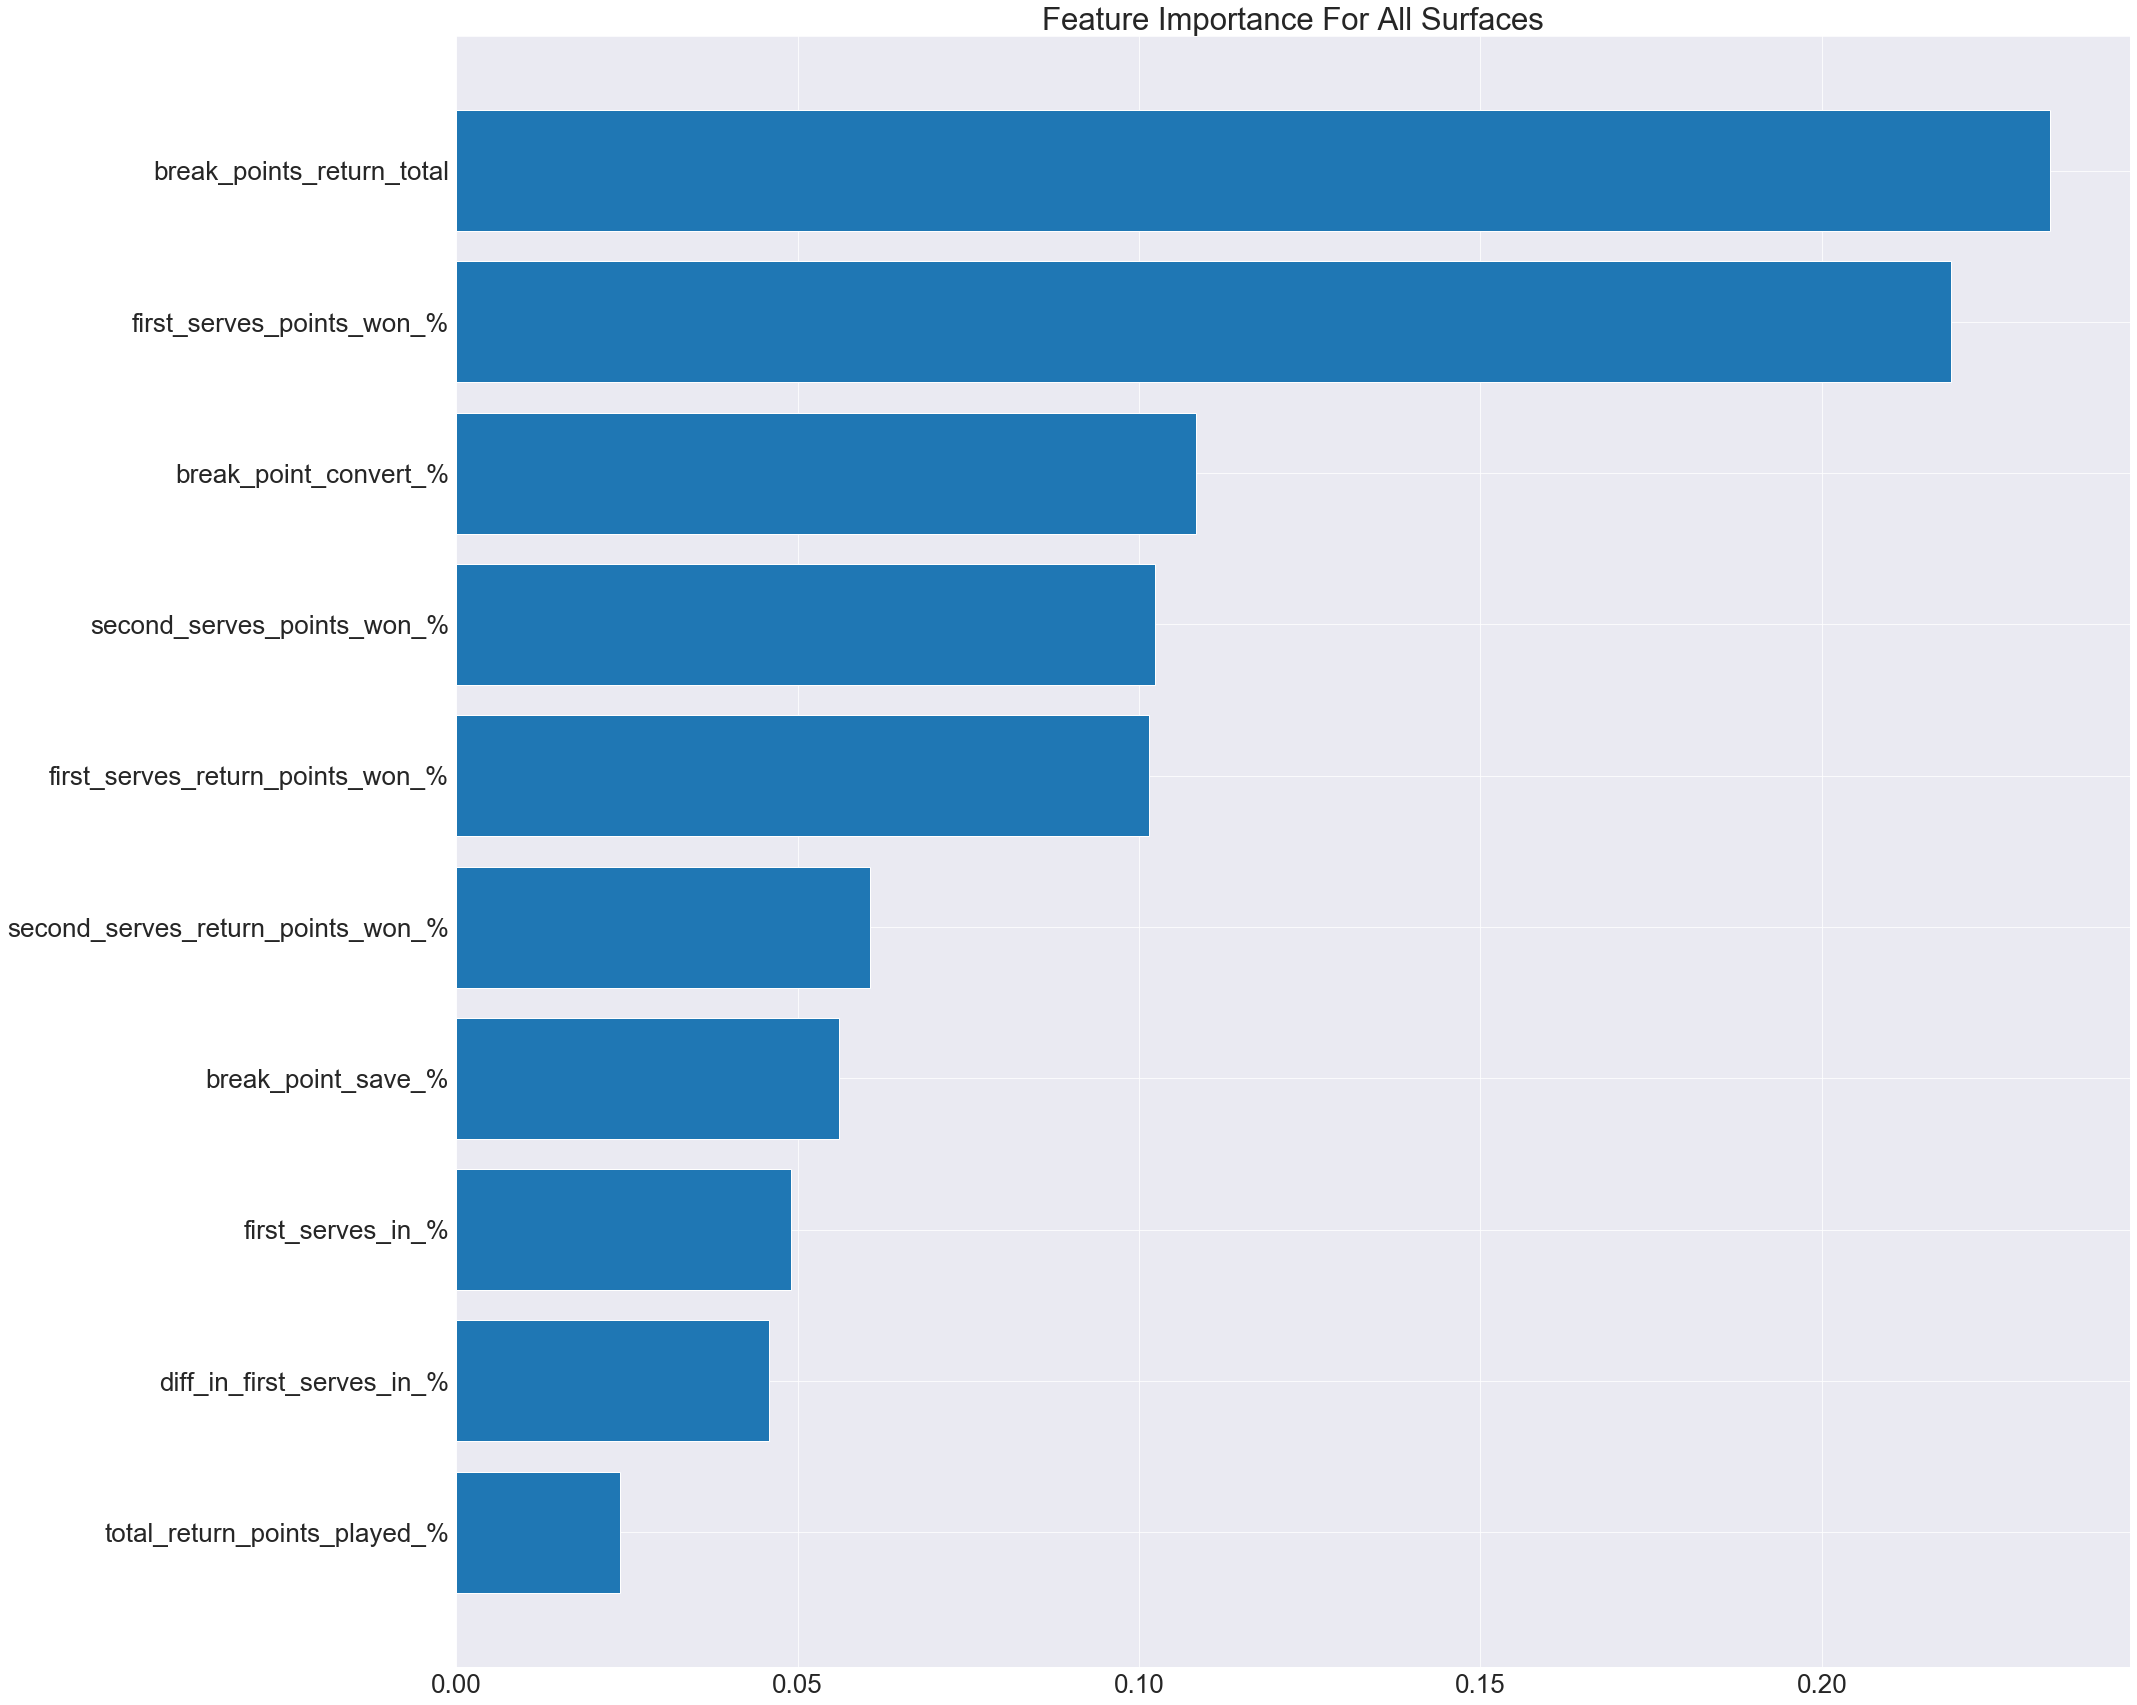

In [205]:
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)),importances[indices], align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);
plt.title('Feature Importance For All Surfaces')
plt.rcParams.update({'font.size': 26})

# Match Analysis Models

In [174]:
# Read CSV
df = pd.read_csv('index_csv/merged_df_v1.1.csv')

In [175]:
# Define features for 2 different analysis
improvable_serve_stats = ['first_serves_in_%', 'first_serves_points_won_%', 
                          'second_serves_points_won_%', 'break_point_save_%']

improvable_return_stats = ['first_serves_return_points_won_%', 'second_serves_return_points_won_%', 
                           'break_point_convert_%']

improvable_stats = improvable_serve_stats + improvable_return_stats

match_analysis = improvable_stats + \
                ['total_return_points_played_%', 'diff_in_first_serves_in_%',
                 'break_points_return_total']

In [176]:
# Define independent and dependent variable
y = df['winner']
X = df[match_analysis]

# 80:20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

# 80:20 Train Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.2,
                                                            random_state=42
                                                            )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

# Re-index y_validate, y_test
y_validate.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

# Apply MinMaxScaler on Train, Validate, Test Data
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_validate)
scaler.transform(X_test)

array([[0.49423248, 0.66470588, 0.42105263, ..., 0.3218921 , 0.48750794,
        0.14705882],
       [0.12207358, 0.81314879, 0.71428571, ..., 0.54434334, 0.24925892,
        0.17647059],
       [0.38618926, 0.88235294, 0.625     , ..., 0.61374822, 0.48309171,
        0.20588235],
       ...,
       [0.39130435, 0.77941176, 0.71428571, ..., 0.64912059, 0.58249969,
        0.26470588],
       [0.61277174, 0.52941176, 0.21052632, ..., 0.32213487, 0.40368851,
        0.02941176],
       [0.5256917 , 0.81848739, 0.45      , ..., 0.57849867, 0.51562501,
        0.29411765]])

## Logistic Regression

In [317]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [318]:
print(cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=kfold))

print(f"Average Train AUC: {sum(cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=kfold))/5}")

[0.95038041 0.94884523 0.94860417 0.94770896 0.94723091]
Average Train AUC: 0.9485539371986682


In [319]:
y_score = logreg.fit(X_train, y_train).decision_function(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.949208027984249


__Train AUC: 94.86 %__

__Validation AUC: 94.92 %__

In [320]:
y_predict = logreg.predict(X_validate)

prediction = []
for i in range(0, len(y_validate)):
    if y_predict[i] == y_validate[i]:
        prediction.append(1)
    else:
        prediction.append(0)
        
pred = pd.DataFrame(prediction)
print(f"Validation Prediction Accuracy = {pred[0].sum()/pred[0].value_counts().sum()}")

Validation Prediction Accuracy = 0.8751483503441728


## Decision Tree

### Parameter Set 1

In [363]:
param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(5,20)],
              'min_samples_leaf' : [100, 500, 1000, 5000]}

In [364]:
dtree = DecisionTreeClassifier()

grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [365]:
grid = grid.fit(X_train, y_train)
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 17
min_samples_leaf: 100
ROC_AUC: 0.97348


In [366]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.9132375142265816


### Parameter Set 2

In [322]:
param_grid = {'criterion' : ['entropy'],
              'max_depth' : [15, 16, 17, 18, 19],
              'min_samples_leaf' : [30, 50, 100, 150, 200]}

In [323]:
dtree = DecisionTreeClassifier()

grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [324]:
grid = grid.fit(X_train, y_train)
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 18
min_samples_leaf: 50
ROC_AUC: 0.97507


In [325]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.9201377759610041


__Train AUC: 97.51 %__

__Validation AUC: 92.01 %__

## Random Forest

### Parameter Set 1

In [332]:
param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(5, 20)],
              'min_samples_leaf' : [100, 500, 1000, 5000]
             }

In [333]:
rfc = RandomForestClassifier()

grid = GridSearchCV(estimator = rfc, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [334]:
grid = grid.fit(X_train, y_train)
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 13
min_samples_leaf: 100
ROC_AUC: 0.98416


In [335]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.9324100144022508


### Parameter Set 2

In [328]:
param_grid = {'criterion' : ['entropy'],
              'max_depth' : [15, 16, 17, 18, 19, 20, 21],
              'min_samples_leaf' : [15, 30, 50, 100, 150, 200]
             }

In [329]:
rfc = RandomForestClassifier()

grid = GridSearchCV(estimator = rfc, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [330]:
grid = grid.fit(X_train, y_train)
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 15
min_samples_leaf: 15
ROC_AUC: 0.9887


In [331]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.944791135996972


__Train AUC: 98.87 %__

__Validation AUC: 94.48 %__

## AdaBoost

### AdaBoost Baseline Model

In [468]:
ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [469]:
# Predict for Train & Validation Data
training_preds = ada_clf.predict(X_train)
validate_preds = ada_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 93.24%
Validation ROC_AUC: 93.26%


In [470]:
ada_clf.feature_importances_

array([0.06, 0.16, 0.16, 0.1 , 0.12, 0.08, 0.12, 0.06, 0.  , 0.14])

### Feature Reduction 1

In [472]:
to_drop = ['first_serves_in_%', 'second_serves_return_points_won_%',
          'total_return_points_played_%', 'diff_in_first_serves_in_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

In [473]:
ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [474]:
# Predict for Train & Validation Data
training_preds = ada_clf.predict(X_train)
validate_preds = ada_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 92.01%
Validation ROC_AUC: 91.94%


### Parameter Set 1

In [475]:
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 0.7, 1.0],
    'n_estimators': [30, 50, 70, 100],
}

In [476]:
grid_clf = GridSearchCV(ada_clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

grid_clf.best_params_

{'learning_rate': 0.3, 'n_estimators': 100}

In [477]:
# Predict for Train & Validation Data
training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 92.43%
Validation ROC_AUC: 92.45%


### Parameter Set 2

In [479]:
param_grid = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [100, 150, 200, 250],
}

In [480]:
grid_clf = GridSearchCV(ada_clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

grid_clf.best_params_

{'learning_rate': 0.3, 'n_estimators': 200}

In [482]:
# Predict for Train & Validation Data
training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 92.53%
Validation ROC_AUC: 92.6%


## XGBoost

### XGBoost Baseline Model

In [372]:
# Instantiate XGBoost & Fit Train Data
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [373]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 94.93%
Validation ROC_AUC: 94.67%


In [374]:
clf.feature_importances_

array([0.0226086 , 0.12215342, 0.13387422, 0.08531456, 0.1123847 ,
       0.1512565 , 0.1116992 , 0.01318798, 0.05084506, 0.19667573],
      dtype=float32)

### Feature Reduction 1

In [375]:
to_drop = ['first_serves_in_%', 'break_point_save_%',
          'total_return_points_played_%', 'diff_in_first_serves_in_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

In [376]:
# Instantiate XGBoost & Fit Train Data
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [377]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 92.59%
Validation ROC_AUC: 92.34%


In [378]:
clf.feature_importances_

array([0.15173542, 0.16110462, 0.1472048 , 0.1698678 , 0.14377822,
       0.22630912], dtype=float32)

### Parameter Set 1

In [384]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.25, 0.5],
    'max_depth': [5, 8, 10, 13],
    'min_child_weight': [0.1, 0.5, 1.0],
    'subsample': [1.0],
    'n_estimators': [100],
}

In [385]:
grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

In [386]:
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 1.0
n_estimators: 100
subsample: 1.0
Training ROC_AUC: 92.88%
Validation ROC_AUC: 92.49%


### Parameter Set 2

In [388]:
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1.0],
    'subsample': [1.0],
    'n_estimators': [100],
}

In [389]:
grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

In [390]:
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 1.0
n_estimators: 100
subsample: 1.0
Training ROC_AUC: 92.88%
Validation ROC_AUC: 92.49%


## Logistic Regression with Feature Reduction

In [100]:
to_drop = ['first_serves_in_%', 'break_point_save_%',
          'total_return_points_played_%', 'diff_in_first_serves_in_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

In [101]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
print(cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=kfold))

print(f"Average Train AUC: {sum(cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=kfold))/5}")

[0.73947372 0.73732801 0.73818023 0.72963376 0.73048147]
Average Train AUC: 0.7350194401084339


In [103]:
y_score = logreg.fit(X_train, y_train).decision_function(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.736586475332557


__Train AUC: 73.50 %__

__Validation AUC: 73.66 %__

In [104]:
y_predict = logreg.predict(X_validate)

prediction = []
for i in range(0, len(y_validate)):
    if y_predict[i] == y_validate[i]:
        prediction.append(1)
    else:
        prediction.append(0)
        
pred = pd.DataFrame(prediction)
print(f"Validation Prediction Accuracy = {pred[0].sum()/pred[0].value_counts().sum()}")

Validation Prediction Accuracy = 0.6718320843647214


## Decision Tree with Feature Reduction

In [108]:
to_drop = ['first_serves_in_%', 'break_point_save_%',
          'total_return_points_played_%', 'diff_in_first_serves_in_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

### Parameter Set 1

In [109]:
param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(5,20)],
              'min_samples_leaf' : [100, 500, 1000, 5000]}

In [110]:
dtree = DecisionTreeClassifier()

grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [111]:
grid = grid.fit(X_train, y_train)
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 17
min_samples_leaf: 100
ROC_AUC: 0.96953


In [112]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.904476246965757


### Parameter Set 2

In [124]:
param_grid = {'criterion' : ['entropy'],
              'max_depth' : [16, 17, 18],
              'min_samples_leaf' : [100]}

In [125]:
dtree = DecisionTreeClassifier()

grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [126]:
grid = grid.fit(X_train, y_train)
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 18
min_samples_leaf: 100
ROC_AUC: 0.96952


In [127]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.904476246965757


## Random Forest with Feature Reduction

In [177]:
to_drop = ['first_serves_in_%', 'break_point_save_%',
          'total_return_points_played_%', 'diff_in_first_serves_in_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

### Parameter Set 1

In [130]:
param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(5, 20)],
              'min_samples_leaf' : [100, 500, 1000, 5000]
             }

In [131]:
rfc = RandomForestClassifier()

grid = GridSearchCV(estimator = rfc, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [132]:
grid = grid.fit(X_train, y_train)
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 14
min_samples_leaf: 100
ROC_AUC: 0.97662


In [133]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.9167873285544511


### Parameter Set 2

In [134]:
param_grid = {'criterion' : ['entropy'],
              'max_depth' : [13, 14, 15],
              'min_samples_leaf' : [100]
             }

In [135]:
rfc = RandomForestClassifier()

grid = GridSearchCV(estimator = rfc, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [136]:
grid = grid.fit(X_train, y_train)
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 14
min_samples_leaf: 100
ROC_AUC: 0.97658


In [137]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.9164030824170412


## Model Selection

|        Model        | Train AUC | Validation AUC |
|:-------------------:|:---------:|:--------------:|
| Logistic Regression |   73.50   |      73.66     |
|    Decision Tree    |   96.95   |      90.45     |
|    Random Forest    |   97.66   |      91.64     |
|       AdaBoost      |   92.53   |      92.60     |
|       XGBoost       |   92.88   |      92.49     |

__All models compared above only uses 6 features.__

__AdaBoost was selected as it optimizes both performance and robustness between different data points.__

## Final Model on Test Data

In [6]:
# Read CSV
df = pd.read_csv('index_csv/merged_df_v1.1.csv')

In [7]:
# Define features for 2 different analysis
improvable_serve_stats = ['first_serves_in_%', 'first_serves_points_won_%', 
                          'second_serves_points_won_%', 'break_point_save_%']

improvable_return_stats = ['first_serves_return_points_won_%', 'second_serves_return_points_won_%', 
                           'break_point_convert_%']

improvable_stats = improvable_serve_stats + improvable_return_stats

match_analysis = improvable_stats + \
                ['total_return_points_played_%', 'diff_in_first_serves_in_%',
                 'break_points_return_total']

In [8]:
# Define independent and dependent variable
y = df['winner']
X = df[match_analysis]

# 80:20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

# 80:20 Train Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.2,
                                                            random_state=42
                                                            )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

# Re-index y_validate, y_test
y_validate.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

# Apply MinMaxScaler on Train, Validate, Test Data
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_validate)
scaler.transform(X_test)

array([[0.49423248, 0.66470588, 0.42105263, ..., 0.3218921 , 0.48750794,
        0.14705882],
       [0.12207358, 0.81314879, 0.71428571, ..., 0.54434334, 0.24925892,
        0.17647059],
       [0.38618926, 0.88235294, 0.625     , ..., 0.61374822, 0.48309171,
        0.20588235],
       ...,
       [0.39130435, 0.77941176, 0.71428571, ..., 0.64912059, 0.58249969,
        0.26470588],
       [0.61277174, 0.52941176, 0.21052632, ..., 0.32213487, 0.40368851,
        0.02941176],
       [0.5256917 , 0.81848739, 0.45      , ..., 0.57849867, 0.51562501,
        0.29411765]])

In [9]:
to_drop = ['first_serves_in_%', 'second_serves_return_points_won_%',
          'total_return_points_played_%', 'diff_in_first_serves_in_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)
X_test.drop(to_drop, axis = 1, inplace = True)

### Final Model on All Surfaces

In [10]:
ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [11]:
param_grid = {
    'learning_rate': [0.3],
    'n_estimators': [200],
}

grid_clf = GridSearchCV(ada_clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.3], 'n_estimators': [200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [12]:
# Predict for Train & Validation Data
training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 92.53%
Validation ROC_AUC: 92.6%


In [13]:
test_preds = grid_clf.predict(X_test)
test_roc_auc = roc_auc_score(y_test, test_preds)

print('Test ROC_AUC: {:.4}%'.format(test_roc_auc * 100))

Test ROC_AUC: 92.63%


In [14]:
predictions = grid_clf.predict(X_test)

confusion_matrix(y_test, predictions)

array([[16970,  1478],
       [ 1240, 17176]], dtype=int64)

### Save Model via Joblib

In [127]:
# Save final trained model
joblib.dump(grid_clf, 'analysis.pkl')

['analysis.pkl']

In [128]:
# To load the fully trained model
analysis = joblib.load('analysis.pkl')

# Pre-Match Prediction Models

In [29]:
# Read CSV
df = pd.read_csv('index_csv/merged_df_v1.1.csv')

In [30]:
# Define features for 2 different analysis
improvable_serve_stats = ['first_serves_in_%', 'first_serves_points_won_%', 
                          'second_serves_points_won_%', 'break_point_save_%']

improvable_return_stats = ['first_serves_return_points_won_%', 'second_serves_return_points_won_%', 
                           'break_point_convert_%']

improvable_stats = improvable_serve_stats + improvable_return_stats

match_analysis = improvable_stats + \
                ['total_return_points_played_%', 'diff_in_first_serves_in_%',
                 'break_points_return_total']

In [31]:
# Define independent and dependent variable
y = df['winner']
X = df[improvable_stats]

# 80:20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

# 80:20 Train Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.2,
                                                            random_state=42
                                                            )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

# Re-index y_validate, y_test
y_validate.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

# Apply MinMaxScaler on Train, Validate, Test Data
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_validate)
scaler.transform(X_test)

array([[0.49423248, 0.66470588, 0.42105263, ..., 0.2877193 , 0.33333333,
        0.05      ],
       [0.12207358, 0.81314879, 0.71428571, ..., 0.4495614 , 0.54545455,
        0.0625    ],
       [0.38618926, 0.88235294, 0.625     , ..., 0.33909774, 0.65517241,
        0.07142857],
       ...,
       [0.39130435, 0.77941176, 0.71428571, ..., 0.29048583, 0.70588235,
        0.05555556],
       [0.61277174, 0.52941176, 0.21052632, ..., 0.26043557, 0.4       ,
        0.125     ],
       [0.5256917 , 0.81848739, 0.45      , ..., 0.43157895, 0.56      ,
        0.05      ]])

## Logistic Regression

In [25]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
print(cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=kfold))

print(f"Average Train AUC: {sum(cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=kfold))/5}")

[0.82005035 0.81472872 0.81956567 0.81354218 0.81007687]
Average Train AUC: 0.815592756906217


In [27]:
y_score = logreg.fit(X_train, y_train).decision_function(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.8190735036162093


In [28]:
y_predict = logreg.predict(X_validate)

prediction = []
for i in range(0, len(y_validate)):
    if y_predict[i] == y_validate[i]:
        prediction.append(1)
    else:
        prediction.append(0)
        
pred = pd.DataFrame(prediction)
print(f"Validation Prediction Accuracy = {pred[0].sum()/pred[0].value_counts().sum()}")

Validation Prediction Accuracy = 0.7365636973992066


## Decision Tree

### Parameter Set 1

In [264]:
param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(5,20)],
              'min_samples_leaf' : [100, 500, 1000, 5000]}

In [265]:
dtree = DecisionTreeClassifier()

grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [266]:
grid = grid.fit(X_train, y_train)
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 16
min_samples_leaf: 100
ROC_AUC: 0.96989


In [267]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.906789087223887


### Parameter Set 2

In [268]:
param_grid = {'criterion' : ['entropy'],
              'max_depth' : [15, 16, 17, 18, 19],
              'min_samples_leaf' : [30, 50, 100, 150, 200]}

In [269]:
dtree = DecisionTreeClassifier()

grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [270]:
grid = grid.fit(X_train, y_train)
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 16
min_samples_leaf: 50
ROC_AUC: 0.97078


In [271]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.9111204212630981


## Random Forest

### Parameter Set 1

In [296]:
param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(5, 20)],
              'min_samples_leaf' : [100, 500, 1000, 5000]
             }

In [297]:
rfc = RandomForestClassifier()

grid = GridSearchCV(estimator = rfc, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [298]:
grid = grid.fit(X_train, y_train)
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 16
min_samples_leaf: 100
ROC_AUC: 0.98017


In [299]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.9250354918882695


### Parameter Set 2

In [300]:
param_grid = {'criterion' : ['entropy'],
              'max_depth' : [15, 16, 17],
              'min_samples_leaf' : [15, 30, 50, 100, 150, 200]
             }

In [301]:
rfc = RandomForestClassifier()

grid = GridSearchCV(estimator = rfc, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [302]:
grid = grid.fit(X_train, y_train)
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: entropy
max_depth: 16
min_samples_leaf: 15
ROC_AUC: 0.98263


In [303]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.9301556469823274


__Train AUC: 98.26 %__

__Validation AUC: 93.02 %__

## AdaBoost

In [70]:
ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [71]:
# Predict for Train & Validation Data
training_preds = ada_clf.predict(X_train)
validate_preds = ada_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 92.69%
Validation ROC_AUC: 92.6%


In [72]:
ada_clf.feature_importances_

array([0.06, 0.18, 0.18, 0.12, 0.2 , 0.14, 0.12])

### Feature Reduction 1

In [73]:
to_drop = ['first_serves_in_%', 'first_serves_points_won_%', 'first_serves_return_points_won_%', 'break_point_save_%',
           'second_serves_points_won_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

In [74]:
ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [75]:
# Predict for Train & Validation Data
training_preds = ada_clf.predict(X_train)
validate_preds = ada_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 75.95%
Validation ROC_AUC: 75.9%


### Parameter Set 1

In [76]:
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 0.7, 1.0],
    'n_estimators': [30, 50, 70, 100],
}

In [77]:
grid_clf = GridSearchCV(ada_clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

grid_clf.best_params_

{'learning_rate': 1.0, 'n_estimators': 100}

In [78]:
# Predict for Train & Validation Data
training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 76.25%
Validation ROC_AUC: 76.32%


### Parameter Set 2

In [79]:
param_grid = {
    'learning_rate': [1.0, 1.5, 2.0],
    'n_estimators': [100, 150, 200, 250],
}

In [80]:
grid_clf = GridSearchCV(ada_clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

grid_clf.best_params_

{'learning_rate': 1.5, 'n_estimators': 200}

In [81]:
# Predict for Train & Validation Data
training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 76.47%
Validation ROC_AUC: 76.54%


## XGBoost

### XGBoost Baseline Model

In [85]:
# Instantiate XGBoost & Fit Train Data
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [86]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 93.54%
Validation ROC_AUC: 93.33%


In [87]:
clf.feature_importances_

array([0.03227242, 0.18603456, 0.15467806, 0.11379876, 0.1671531 ,
       0.19471933, 0.15134376], dtype=float32)

### Feature Reduction 1

In [88]:
to_drop = ['first_serves_in_%', 'first_serves_points_won_%', 'first_serves_return_points_won_%', 'break_point_save_%',
           'second_serves_points_won_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

In [89]:
# Instantiate XGBoost & Fit Train Data
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [90]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 76.5%
Validation ROC_AUC: 76.5%


### Parameter Set 1

In [91]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.25],
    'max_depth': [5, 8, 10, 13],
    'min_child_weight': [0.1, 0.5, 1.0],
    'subsample': [1.0],
    'n_estimators': [100],
}

In [92]:
grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

In [93]:
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.25
max_depth: 5
min_child_weight: 0.5
n_estimators: 100
subsample: 1.0
Training ROC_AUC: 77.03%
Validation ROC_AUC: 76.82%


### Parameter Set 2

In [94]:
param_grid = {
    'learning_rate': [0.2, 0.25, 0.3],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [0.3, 0.4, 0.5, 0.6],
    'subsample': [1.0],
    'n_estimators': [100],
}

In [95]:
grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

In [96]:
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 4
min_child_weight: 0.5
n_estimators: 100
subsample: 1.0
Training ROC_AUC: 76.89%
Validation ROC_AUC: 76.73%


## Logistic Regression with Feature Reduction

In [144]:
to_drop = ['first_serves_in_%', 'first_serves_points_won_%', 'first_serves_return_points_won_%', 'break_point_save_%',
           'second_serves_points_won_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

In [145]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [146]:
print(cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=kfold))

print(f"Average Train AUC: {sum(cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=kfold))/5}")

[0.6786007  0.67077326 0.67271871 0.66096869 0.6654967 ]
Average Train AUC: 0.6697116117881912


In [147]:
y_score = logreg.fit(X_train, y_train).decision_function(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.6732143114537801


In [148]:
y_predict = logreg.predict(X_validate)

prediction = []
for i in range(0, len(y_validate)):
    if y_predict[i] == y_validate[i]:
        prediction.append(1)
    else:
        prediction.append(0)
        
pred = pd.DataFrame(prediction)
print(f"Validation Prediction Accuracy = {pred[0].sum()/pred[0].value_counts().sum()}")

Validation Prediction Accuracy = 0.6533179614119562


## Decision Tree with Feature Reduction

In [152]:
to_drop = ['first_serves_in_%', 'first_serves_points_won_%', 'first_serves_return_points_won_%', 'break_point_save_%',
           'second_serves_points_won_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

### Parameter Set 1

In [153]:
param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(5,20)],
              'min_samples_leaf' : [100, 500, 1000, 5000]}

In [154]:
dtree = DecisionTreeClassifier()

grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [155]:
grid = grid.fit(X_train, y_train)
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: gini
max_depth: 11
min_samples_leaf: 100
ROC_AUC: 0.84946


In [156]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.7668134418382427


### Parameter Set 2

In [157]:
param_grid = {'criterion' : ['gini'],
              'max_depth' : [10, 11, 12],
              'min_samples_leaf' : [50, 70, 100]}

In [158]:
dtree = DecisionTreeClassifier()

grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [159]:
grid = grid.fit(X_train, y_train)
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: gini
max_depth: 11
min_samples_leaf: 100
ROC_AUC: 0.84946


In [160]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.7668134418382427


## Random Forest with Feature Reduction

In [164]:
to_drop = ['first_serves_in_%', 'first_serves_points_won_%', 'first_serves_return_points_won_%', 'break_point_save_%',
           'second_serves_points_won_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)

### Parameter Set 1

In [165]:
param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(5, 20)],
              'min_samples_leaf' : [100, 500, 1000, 5000]
             }

In [166]:
rfc = RandomForestClassifier()

grid = GridSearchCV(estimator = rfc, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [167]:
grid = grid.fit(X_train, y_train)
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: gini
max_depth: 15
min_samples_leaf: 100
ROC_AUC: 0.84925


In [168]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.767455412753388


### Parameter Set 2

In [169]:
param_grid = {'criterion' : ['gini'],
              'max_depth' : [14, 15, 16],
              'min_samples_leaf' : [50, 70, 100]
             }

In [170]:
rfc = RandomForestClassifier()

grid = GridSearchCV(estimator = rfc, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [171]:
grid = grid.fit(X_train, y_train)
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']

print(f'criterion: {criterion}')
print(f'max_depth: {round(max_depth,5)}')
print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
print(f'ROC_AUC: {round(grid.best_score_,5)}')

criterion: gini
max_depth: 14
min_samples_leaf: 50
ROC_AUC: 0.84978


In [172]:
y_score = grid.predict(X_validate)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print(f"Validation AUC: {auc(fpr, tpr)}")

Validation AUC: 0.7663973618431503


* Parameter Set 1 performed better than Set 2

## Model Selection

|        Model        | Train AUC | Validation AUC |
|:-------------------:|:---------:|:--------------:|
| Logistic Regression |   66.97   |      67.32     |
|    Decision Tree    |   84.95   |      76.68     |
|    Random Forest    |   84.93   |      76.75     |
|       AdaBoost      |   76.47   |      76.54     |
|       XGBoost       |   76.89   |      76.73     |

__All models compared above only uses 2 features.__

__XGBoost was selected as it optimizes both performance and robustness between different data points.__

## Final Model on Test Data

In [32]:
# Read CSV
df = pd.read_csv('index_csv/merged_df_v1.1.csv')

In [33]:
# Define features for 2 different analysis
improvable_serve_stats = ['first_serves_in_%', 'first_serves_points_won_%', 
                          'second_serves_points_won_%', 'break_point_save_%']

improvable_return_stats = ['first_serves_return_points_won_%', 'second_serves_return_points_won_%', 
                           'break_point_convert_%']

improvable_stats = improvable_serve_stats + improvable_return_stats

match_analysis = improvable_stats + \
                ['total_return_points_played_%', 'diff_in_first_serves_in_%',
                 'break_points_return_total']

In [34]:
# Define independent and dependent variable
y = df['winner']
X = df[improvable_stats]

# 80:20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

# 80:20 Train Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.2,
                                                            random_state=42
                                                            )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

# Re-index y_validate, y_test
y_validate.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

# Apply MinMaxScaler on Train, Validate, Test Data
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_validate)
scaler.transform(X_test)

array([[0.49423248, 0.66470588, 0.42105263, ..., 0.2877193 , 0.33333333,
        0.05      ],
       [0.12207358, 0.81314879, 0.71428571, ..., 0.4495614 , 0.54545455,
        0.0625    ],
       [0.38618926, 0.88235294, 0.625     , ..., 0.33909774, 0.65517241,
        0.07142857],
       ...,
       [0.39130435, 0.77941176, 0.71428571, ..., 0.29048583, 0.70588235,
        0.05555556],
       [0.61277174, 0.52941176, 0.21052632, ..., 0.26043557, 0.4       ,
        0.125     ],
       [0.5256917 , 0.81848739, 0.45      , ..., 0.43157895, 0.56      ,
        0.05      ]])

In [134]:
to_drop = ['first_serves_in_%', 'first_serves_points_won_%', 'first_serves_return_points_won_%', 'break_point_save_%',
           'second_serves_points_won_%']

X_train.drop(to_drop, axis = 1, inplace = True)
X_validate.drop(to_drop, axis = 1, inplace = True)
X_test.drop(to_drop, axis = 1, inplace = True)

### Final Model On All Surfaces

In [35]:
# Instantiate XGBoost & Fit Train Data
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [36]:
param_grid = {
    'learning_rate': [0.2],
    'max_depth': [4],
    'min_child_weight': [0.5],
    'subsample': [1.0],
    'n_estimators': [100],
}

In [37]:
grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

In [38]:
training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 93.98%
Validation ROC_AUC: 93.53%


In [39]:
test_preds = grid_clf.predict(X_test)
test_roc_auc = roc_auc_score(y_test, test_preds)

print('Test ROC_AUC: {:.4}%'.format(test_roc_auc * 100))

Test ROC_AUC: 93.47%


In [48]:
predictions = grid_clf.predict(X_test)

confusion_matrix(y_test, predictions)

array([[17204,  1244],
       [ 1162, 17254]], dtype=int64)

### Save Model via Joblib

In [116]:
# Save final trained model
joblib.dump(grid_clf, 'prediction.pkl')

['prediction.pkl']

In [117]:
# To load the fully trained model
prediction = joblib.load('prediction.pkl')

# Case Study : Wimbledon 2019 Final

We will conduct the case study in 2 parts, the first part is the pre-match prediction and the second part is the post-match analysis.

__Djokovic beats Federer in Wimbledon 2019 Final over 5 sets in 4 hours and 57 minutes__

__Final Score: Djokovic 7-6(5) 1-6 7-6(4) 4-6 13-12(3) Federer__

--------------------------------------------------------------------------------------------------------------

The pre-match prediction model uses only 2 metrics: 
* __second_serves_return_points_won_%__
* __break_point_convert_%__

For this case study, we will use the following pre-match statistics available to us:
* __Tournament Average across first 6 matches before final__
* __YTD (2019) Player Statistics__
* __Previous H2H Accumulated Statistics prior to the match__

--------------------------------------------------------------------------------------------------------------

The match analysis model uses 6 metrics:
* __first_serves_points_won_%__
* __second_serves_points_won_%__
* __break_point_save_%__
* __first_serves_return_points_won_%__
* __break_point_convert_%__
* __break_points_return_total__

For this case study, we will use the following match statistics available to us:
* __Full Match Statistics__
* __Individual Sets Statistics__
* __Cumulative Win Probability over 5 sets__

## Extract Trained Models 

In [3]:
# Load the trained models
prediction = joblib.load('prediction.pkl')  # for pre-match prediction

analysis = joblib.load('analysis.pkl')      # for match analysis

## Data Preparation

In [4]:
# Load main dataset on matches
df_match = pd.read_csv('index_csv/clean_df_v3.0.csv')

In [5]:
# Load case study file
df_wim_2019_final = df_match[df_match['match_id'] == '2019-540-MS001-10-1-d643-f324']

# Remove from matches data
df_match = df_match[df_match['match_id'] != '2019-540-MS001-10-1-d643-f324']
df_match.reset_index(drop = True, inplace = True)

In [6]:
# Define features required for each analysis
pre_match = ['second_serves_return_points_won_%', 'break_point_convert_%']

match_analysis = ['first_serves_points_won_%', 'second_serves_points_won_%', 'break_point_save_%',
                  'first_serves_return_points_won_%', 'break_point_convert_%', 'break_points_return_total']

### Tournament Performance

Here we wil extract the 6 matches for both players, Novak Djokovic and Roger Federer, leading up to the final. We will calculate the performance of the 2 features required by the model from the first 6 matches, which would account for their form going into the final.

In [7]:
# Extract the 6 matches that both players played before final

df_2019 = df_match[df_match['year'] == 2019]
df_wim_2019 = df_2019[df_2019['tourney_slug'] == 'wimbledon']

df_djokovic = df_wim_2019[df_wim_2019['slug'] == 'd643']
df_federer = df_wim_2019[df_wim_2019['slug'] == 'f324']

In [8]:
# Extract raw stats required to compute statistics

raw_stats = ['second_serve_return_won', 'second_serve_return_total',
            'break_points_converted', 'break_points_return_total']

df_djokovic = df_djokovic[raw_stats]
df_federer = df_federer[raw_stats]

In [9]:
djokovic_1 = df_djokovic.sum()[0] / df_djokovic.sum()[1]
djokovic_2 = df_djokovic.sum()[2] / df_djokovic.sum()[3]

federer_1 = df_federer.sum()[0] / df_federer.sum()[1]
federer_2 = df_federer.sum()[2] / df_federer.sum()[3]

feature_1 = list([djokovic_1, federer_1])
feature_2 = list([djokovic_2, federer_2])

In [10]:
tourney_average = pd.DataFrame(columns = pre_match)

tourney_average['second_serves_return_points_won_%'] = feature_1
tourney_average['break_point_convert_%'] = feature_2

### YTD Player Statistics (01 Jan 2019 - 13 July 2019)

YTD Player Statistics from __1/1/2019 - 13/07/2019__

Wimbledon Final Date: __14/07/2019__

Extracted from: 
- Djokovic: https://www.ultimatetennisstatistics.com/playerProfile?playerId=4920
- Federer: https://www.ultimatetennisstatistics.com/playerProfile?playerId=3819

In [11]:
feature_1 = [0.551, 0.503]
feature_2 = [0.50, 0.396]

ytd_average = pd.DataFrame(columns = pre_match)

ytd_average['second_serves_return_points_won_%'] = feature_1
ytd_average['break_point_convert_%'] = feature_2

### Previous H2H Accumulated Statistics

This section aims to account for both players' performance when they face each other in previous head-to-head matches prior to the match. This dataframe would capture the match dynamic to be expected in this match.

In [12]:
df_djokovic = df_match[df_match['slug'] == 'd643']
df_federer = df_match[df_match['slug'] == 'f324']

df_djokovic.reset_index(drop = True, inplace = True)
df_federer.reset_index(drop = True, inplace = True)

In [13]:
# Filter only djokovic-federer match
for i in range(0,len(df_djokovic)):
    if 'f324' in df_djokovic['match_id'][i]:
        pass
    else:
        df_djokovic.drop(i, inplace = True)
        
# Filter only federer-djokovic match
for i in range(0,len(df_federer)):
    if 'd643' in df_federer['match_id'][i]:
        pass
    else:
        df_federer.drop(i, inplace = True)
        
# Remove the only other match they played in 2019
df_djokovic = df_djokovic[df_djokovic['match_id'] != '2019-605-MS016-1-10-f324-d643']
df_federer = df_federer[df_federer['match_id'] != '2019-605-MS016-1-10-f324-d643']

In [14]:
# Extract raw stats required to compute statistics

raw_stats = ['second_serve_return_won', 'second_serve_return_total',
            'break_points_converted', 'break_points_return_total']

df_djokovic = df_djokovic[raw_stats]
df_federer = df_federer[raw_stats]

In [15]:
djokovic_1 = df_djokovic.sum()[0] / df_djokovic.sum()[1]
djokovic_2 = df_djokovic.sum()[2] / df_djokovic.sum()[3]

federer_1 = df_federer.sum()[0] / df_federer.sum()[1]
federer_2 = df_federer.sum()[2] / df_federer.sum()[3]

feature_1 = list([djokovic_1, federer_1])
feature_2 = list([djokovic_2, federer_2])

In [16]:
h2h_average = pd.DataFrame(columns = pre_match)

h2h_average['second_serves_return_points_won_%'] = feature_1
h2h_average['break_point_convert_%'] = feature_2

### Full Match Statistics

This dataframe consists of 2 lines of data describing the player's individual full match statistics. Player 0 is Novak Djokovic and Player 1 is Roger Federer.

In [17]:
df_full_match = df_wim_2019_final[match_analysis]

### Individual Set Statistics

This dataset aims to capture the performance of both players by individual set during the match. Each set is represented as a row.

In [18]:
df_djokovic_individual_stats = pd.DataFrame(columns = match_analysis)

df_djokovic_individual_stats['first_serves_points_won_%']        = [0.88, 0.27, 0.78, 0.80, 0.74]
df_djokovic_individual_stats['second_serves_points_won_%']       = [0.52, 0.33, 0.69, 0.30, 0.43]
df_djokovic_individual_stats['break_point_save_%']               = [1.00, 0.25, 1.00, 0.00, 0.60]
df_djokovic_individual_stats['first_serves_return_points_won_%'] = [0.25, 0.00, 0.13, 0.24, 0.27]
df_djokovic_individual_stats['break_point_convert_%']            = [0.00, 0.00, 0.00, 0.50, 0.33]
df_djokovic_individual_stats['break_points_return_total']        = [0.00, 0.00, 0.00, 2.00, 6.00]

df_federer_individual_stats = pd.DataFrame(columns = match_analysis)

df_federer_individual_stats['first_serves_points_won_%']        = [0.75, 1.00, 0.88, 0.76, 0.73]
df_federer_individual_stats['second_serves_points_won_%']       = [0.54, 0.33, 0.67, 0.54, 0.50]
df_federer_individual_stats['break_point_save_%']               = [0.00, 0.00, 0.00, 0.50, 0.67]
df_federer_individual_stats['first_serves_return_points_won_%'] = [0.12, 0.73, 0.22, 0.20, 0.26]
df_federer_individual_stats['break_point_convert_%']            = [0.00, 0.75, 0.00, 1.00, 0.40]
df_federer_individual_stats['break_points_return_total']        = [1.00, 4.00, 1.00, 2.00, 5.00]

### Cumulative Over Set Statistics

This section aims to capture the cumulative performance as the match progresses each set, each row will describe the cumulative statistics at the conclusion of each set.

In [19]:
df_djokovic_cumulative_stats = pd.DataFrame(columns = match_analysis)

df_djokovic_cumulative_stats['first_serves_points_won_%']        = [0.88, 0.694, 0.73, 0.7435, 0.743]
df_djokovic_cumulative_stats['second_serves_points_won_%']       = [0.52, 0.466, 0.535, 0.4905, 0.47]
df_djokovic_cumulative_stats['break_point_save_%']               = [1.00, 0.4, 0.5, 0.375, 0.46]
df_djokovic_cumulative_stats['first_serves_return_points_won_%'] = [0.25, 0.189, 0.164, 0.179, 0.21]
df_djokovic_cumulative_stats['break_point_convert_%']            = [0.00, 0.00, 0.00, 0.50, 0.375]
df_djokovic_cumulative_stats['break_points_return_total']        = [0.00, 0.00, 0.00, 2.00, 8.00]

df_federer_cumulative_stats = pd.DataFrame(columns = match_analysis)

df_federer_cumulative_stats['first_serves_points_won_%']        = [0.75, 0.811, 0.836, 0.821, 0.79]
df_federer_cumulative_stats['second_serves_points_won_%']       = [0.54, 0.455, 0.516, 0.523, 0.51]
df_federer_cumulative_stats['break_point_save_%']               = [0.00, 0.00, 0.00, 0.50, 0.625]
df_federer_cumulative_stats['first_serves_return_points_won_%'] = [0.12, 0.306, 0.27, 0.256, 0.26]
df_federer_cumulative_stats['break_point_convert_%']            = [0.00, 0.6, 0.5, 0.625, 0.54]
df_federer_cumulative_stats['break_points_return_total']        = [1.00, 5.00, 6.00, 8.00, 13.0]

## Case Study 

### Prediction Model (XGBoost with Validation AUC: 76.73 %)

As requested, we have prepared 3 sets of data for this case study:
* <code> tourney_average </code> : This data describes both players' performance across first 6 matches leading up to the final
* <code> ytd_average     </code> : This data describes both players' performance from the year 2019 up until the final
* <code> h2h_average     </code> : This data describes both players' performance from all the past head-to-head matches


* Player 0 = Novak Djokovic
* Player 1 = Roger Federer

First we look at the prediction on the tourney average:

In [20]:
prediction.predict(tourney_average)

array([1., 1.])

In [21]:
prediction.predict_proba(tourney_average)

array([[0.2885536 , 0.7114464 ],
       [0.22685748, 0.7731425 ]], dtype=float32)

As this is the accumulated statistics from their first 6 wins of the tournament, the .predict method becomes trivial as they are obviously expected to win with the statistics collected from their wins. 

However, more information can be obtained from the .predict_proba method as we can see who had played better during their first 6 matches before the final. As shown above, we can see Federer being more dominant in his wins, with his statistics describing a __77.31 %__ match win rate compared to Djokovic's __71.14 %__.

This becomes more impressive when taken into account that Federer had also face harder opponents on his run to the final compared to Djokovic.

__Paths To Final:__

| Rounds |       Novak Djokovic       |      Roger Federer     |
|:------:|:--------------------------:|:----------------------:|
|   R1   |    Philipp Kohlschreiber   |      Lloyd Harris      |
|   R2   |         Denis Kudla        |       Jay Clarke       |
|   R3   |       Hubert Hurkacz       |   Lucas Pouille [27]   |
|   R4   |         Ugo Humbert        | Matteo Berrettini [17] |
|   QF   |      David Goffin [21]     |    Kei Nishikori [8]   |
|   SF   | Roberto Bautista-Agut [23] |    Rafael Nadal [3]    |

Federer had faced 4 seeded players and 2 top 10 players (including Rafael Nadal) while Djokovic had not faced any top 20 players before the final. 

Using this dataset as a prediction for the match would give Federer an edge of 2 to 4 % against Djokovic.

Next, we look at the prediction based on their Year-to-Date statistics prior to this final.

In [22]:
prediction.predict(ytd_average)

array([1., 1.])

In [23]:
prediction.predict_proba(ytd_average)

array([[0.32971066, 0.67028934],
       [0.44875884, 0.55124116]], dtype=float32)

Prior to this match, Federer had accumulated 32 Wins and 4 Losses (88.89 %) in 2019 while Djokovic had accumulated 28 Wins and 6 Losses (82.35 %). With this information, the .predict method once again becomes trivial as they both had a successful season at 80 + % win rate. 

However, we can see some interesting figures when we look at the .predict_proba method. Though Federer had a more successful season with higher win rate, Djokovic actually had been more dominant with his game on-court throughout the year, his average match stats gives him a __67.03 %__ of winning any match while Federer had __55.12 %__, indicating less dominant wins in the year compared to Djokovic.

Based on this dataset, we would expect Djokovic to win the final with an edge of 5-10 % over Federer.

Finally, we look at their previous head-to-head records to better capture their contrasting playing style and the match dynamic when the two of them face each other.

In [24]:
prediction.predict(h2h_average)

array([1., 1.])

In [25]:
prediction.predict_proba(h2h_average)

array([[0.48957372, 0.5104263 ],
       [0.39767414, 0.60232586]], dtype=float32)

Before this match, Djokovic held a 25-22 winning record over Federer.

With the .predict method, we can see that both players bring a good level of tennis when they face each other, as both compiled statistics are capable of winning matches based on the model. 

Next, we look at the .predict_proba results, we can see that Federer stats had been more dominant than Djokovic in their past matches, at __60.23 %__ against Djokovic's __51.04 %__. This is a relative dominance ratio of 54:46 in favor to Federer. This is an interesting statistic as Djokovic held a 25-22 winning head-to-head against Federer. 

*This may be due to the matches earlier in their career when Federer was at his prime while Djokovic is still struggling to challenge Federer or Nadal.*

Using this model, Federer would be expected to win the final with an edge of 5-10%. However, this is the least accurate model of the 3 as we are taking into account matches from 2006 - 2018 between them, with no additional bias given to the recent matches, as there had been a dynamic switch during the time period.

### Analysis Model (AdaBoost with Validation AUC: 92.60 %)

As requested, we have prepared 3 sets of data for this case study:
* <code> df_full_match                </code> : This data describes both players' performance during the final
* <code> df_djokovic_individual_stats </code> : This data describes djokovic's performance in each of the 5 sets played
* <code> df_federer_individual_stats </code>  : This data describes federer's performance in each of the 5 sets played
* <code> df_djokovic_cumulative_stats </code> : This data describes djokovic's performance cumulatively at end of each set
* <code> df_federer_cumulative_stats </code>  : This data describes federer's performance cumulatively at end of each set


* Player 0 = Novak Djokovic
* Player 1 = Roger Federer

First, we look at the full match stats.

In [76]:
analysis.predict(df_full_match)

array([0., 1.])

In [77]:
analysis.predict_proba(df_full_match)

array([[0.50579989, 0.49420011],
       [0.48443594, 0.51556406]])

The analysis model that we built predicted a win for Federer based on the full match stats, which perhaps deservedly so as Federer was the better player throughout the whole match, won 14 more points than Djokovic and had 2 match points on his own serve but failed to convert in the final set. This would be a false prediction by the analysis model but it does give insights into the relative performance and which player's performance is more deserving for victory. 

When we look at the win probability for each player, we can see the model predicted a 49.42 % chance of winning for Djokovic and a 51.56 % chance of winning for Federer, which translates to a relative win rate of 51 % to 49 % in favor of Federer. Therefore, Federer did play better than Djokovic and would have probably won the match any other day, but the model shows that Djokovic did not play terrible but was about 4 % below Federer's level on the day. The difference was Djokovic increased his level when it comes to pressure points like facing Federer's break points and match points opportunities. This helped him stay in the match until the 5th set despite playing at a lower level than Federer, we will look into a more detailed set-by-set analysis now.

__Final Score:__
- __Set 1: Djokovic won 7-6(5)__
- __Set 2: Federer won 6-1__
- __Set 3: Djokovic won 7-6(4)__
- __Set 4: Federer won 6-4__
- __Set 5: Djokovic won 13-12(3)__

In [172]:
# Individual Set Outcome Prediction
print(f"Djokovic prediction on each set:{analysis.predict(df_djokovic_individual_stats)}")
print(f"Federer prediction on each set: {analysis.predict(df_federer_individual_stats)}")
print("")

# Chance of Winning in Eact Set by Djokovic
print("Djokovic Chance of Winning in Each Set")
for i in range(0, len(analysis.predict_proba(df_djokovic_individual_stats))):
    print(f"Set {str(1 + i)}: {round(analysis.predict_proba(df_djokovic_individual_stats)[i][1] * 100, 2)} %")
    
print("")

# Chance of Winning in Eact Set by Federer
print("Federer Chance of Winning in Each Set")
for i in range(0, len(analysis.predict_proba(df_federer_individual_stats))):
    print(f"Set {str(1 + i)}: {round(analysis.predict_proba(df_federer_individual_stats)[i][1] * 100, 2)} %")

print("")

# Break Point Chances by Both Players
print (f"Number of Break Point Opportunities:\n")

for i in range(0, len(df_djokovic_individual_stats['break_points_return_total'])):
    print (f"Set {1 + i}: Djokovic   {df_djokovic_individual_stats['break_points_return_total'][i]}      Federer   {df_federer_individual_stats['break_points_return_total'][i]}")

print("-----------------------------------------")
print(f"Total: Djokovic   {df_djokovic_individual_stats['break_points_return_total'].sum()}      Federer  {df_federer_individual_stats['break_points_return_total'].sum()}")

Djokovic prediction on each set:[0. 0. 0. 1. 0.]
Federer prediction on each set: [1. 1. 1. 0. 0.]

Djokovic Chance of Winning in Each Set
Set 1: 45.3 %
Set 2: 38.38 %
Set 3: 45.51 %
Set 4: 52.2 %
Set 5: 49.04 %

Federer Chance of Winning in Each Set
Set 1: 51.54 %
Set 2: 55.36 %
Set 3: 53.16 %
Set 4: 46.73 %
Set 5: 49.64 %

Number of Break Point Opportunities:

Set 1: Djokovic   0.0      Federer   1.0
Set 2: Djokovic   0.0      Federer   4.0
Set 3: Djokovic   0.0      Federer   1.0
Set 4: Djokovic   2.0      Federer   2.0
Set 5: Djokovic   6.0      Federer   5.0
-----------------------------------------
Total: Djokovic   8.0      Federer  13.0


As we conducted an initial analysis on ~100k matches on Section 3 of this document, no player had ever won a match without breaking opponent's serve from 1990-2019. It is theoretically possible but highly improbable as the statistics shows, but assuming they played a normal Best-of-3 Sets match, Djokovic would have been the only player in 2 decades to accomplish that feat. Djokovic had 0 break point opportunities in the first 3 sets as compared to Federer's 6, but ended the set 3 with a 2-1 lead in sets, winning the first and third set via tiebreakers.

As we can see from the predict function above, based on their performance, Federer was forecasted to win the first 3 sets while Djokovic was forecasted to lose all 3 sets. Most tennis speculators think Federer lost the match in the 5th set when he led 8:7 in games and 40:15 in points with 2 match points on his serve, but in reality Federer lost his match in 1st and 3rd set where he played significantly better than Djokovic in the 2 sets but failed to convert his break points to capitalize on his superior performance over djokovic, and partially due to Djokovic stepping up his game in crucial moments to win all 3 tiebreakers that led him to the victory.

When we look at the win probability of each player in each set, we can see fluctuating performance from Djokovic and a consistent performance from Federer before falling in set 4 and 5. This is not surprising as Federer was turning 38 years old in a month during that match and Djokovic was 6 years younger than him, thus giving Djokovic an advantage as the matches went over 3-4 hours as he had better physical endurance.

When we look at the final set, we can see that the model predicted both players to lose, with a probability of winning at 49.04 % for Djokovic and 49.64 % for Federer, signifying that both player's performance are not worthy of winning, but it also shows that both players are playing at a similar level, hence the game went on to the 12-12 in games, requiring a final set tiebreaker to decide the winner. 

Though they played at a similar level in the final set, Djokovic's final set performance was his personal 2nd best set in terms of level of play, while Federer's final set performance was his personal 2nd worst set, indicating Djokovic improved his performance after set 3 and Federer's level falling gradually after set 3. We will try to investigate this further in our next analysis, which looks at the cumulative performance at the conclusion of each set.

Text(0, 0.5, 'Relative Performance')

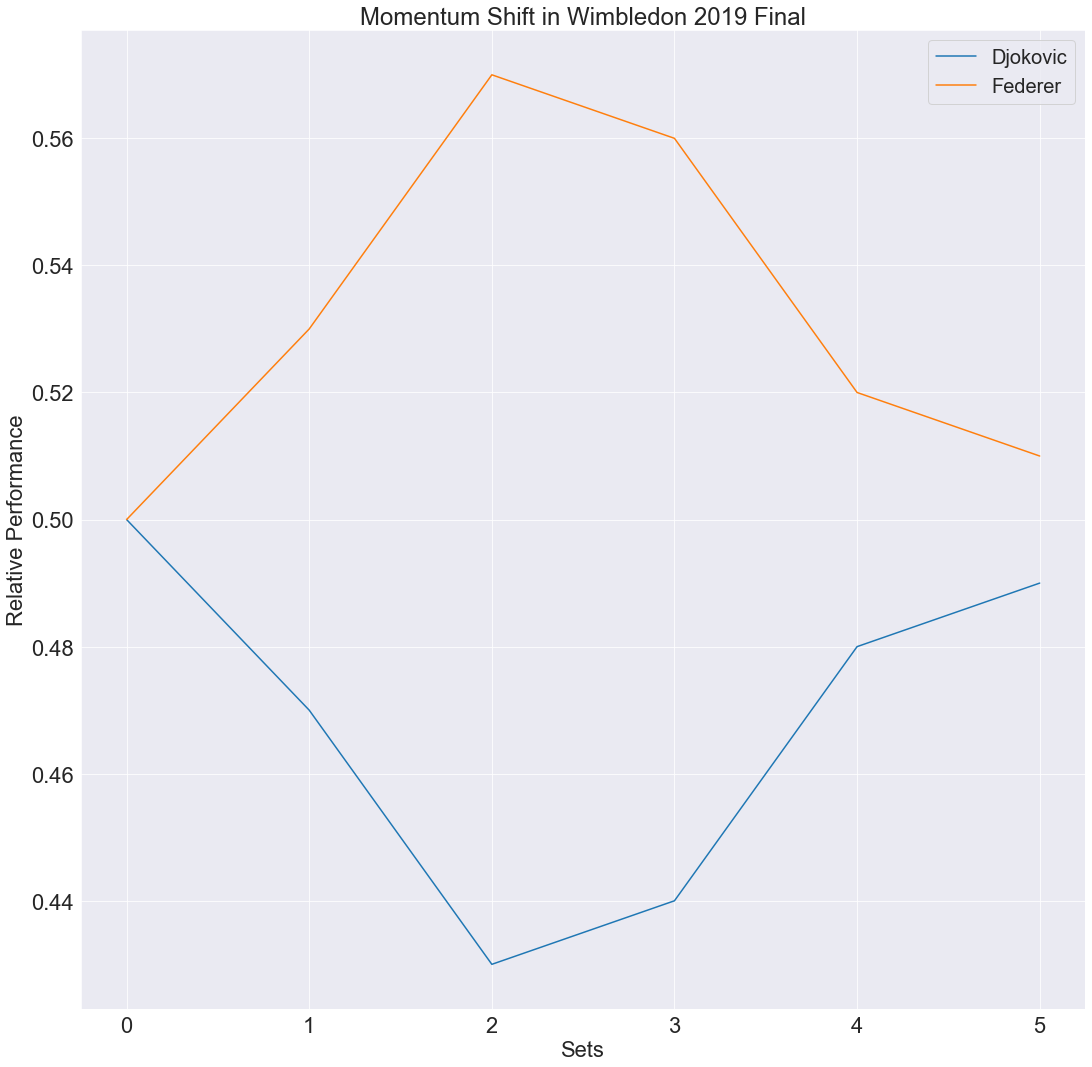

In [168]:
# Calculating relative performance between 2 players

djo_cumulative_performance = []
fed_cumulative_performance = []
for i in range(0, len(analysis.predict_proba(df_djokovic_cumulative_stats))):
    djo_cumulative_performance.append(analysis.predict_proba(df_djokovic_cumulative_stats)[i][1])
    fed_cumulative_performance.append(analysis.predict_proba(df_federer_cumulative_stats)[i][1])

djo_relative_performance = [0.5]
fed_relative_performance = [0.5]
for i in range(0, len(djo_cumulative_performance)):
    djo_relative_performance.append(round(djo_cumulative_performance[i] / (djo_cumulative_performance[i] + fed_cumulative_performance[i]), 2))
    fed_relative_performance.append(round(fed_cumulative_performance[i] / (djo_cumulative_performance[i] + fed_cumulative_performance[i]), 2))


# Plot 2 lines displaying momentum and performance change during the 5 sets
sns.lineplot(x=range(0,6), y=djo_relative_performance)
sns.lineplot(x=range(0,6), y=fed_relative_performance)
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (18,18)
plt.legend(['Djokovic', 'Federer'])
plt.title("Momentum Shift in Wimbledon 2019 Final")
plt.xlabel("Sets")
plt.ylabel("Relative Performance")

Here, we can see the shift in their relative performance from start of the match to the end, showing that Federer gradually increase his dominance over Djokovic from the first point to the end of set 2, with the peak at 57% - 43 % in relative performance in favor of Federer, a staggering 14 % edge over Djokovic. 

After set 2, Federer's relative performance against Djokovic dipped slightly in set 3 and continued to drop further in set 4 and 5, but statistically remain the superior player throughout the whole match from first point to the last point.

### Improvements

In [221]:
# Load djokovic full match stats
df_djo_improve = df_full_match.drop(85168)

# Improvement rate
rate = 1.1
baseline = round(analysis.predict_proba(df_djo_improve)[0][1] * 100, 2)
print(f"Original chance of winning full match: {baseline} %\n")

# Analyze which feature most beneficial for increasing chance of winning
for i in df_djo_improve.columns:
    df_djo_improve = df_full_match.drop(85168)    # Reset values for comparison
    df_djo_improve[i] = df_djo_improve[i] * rate
    prediction = round(analysis.predict_proba(df_djo_improve)[0][1] * 100, 2)
    print(f"{i}: Chance of winning improved by {round((prediction - baseline), 2)} %")

Original chance of winning full match: 49.42 %

first_serves_points_won_%: Chance of winning improved by 0.55 %
second_serves_points_won_%: Chance of winning improved by 0.4 %
break_point_save_%: Chance of winning improved by 0.19 %
first_serves_return_points_won_%: Chance of winning improved by 0.0 %
break_point_convert_%: Chance of winning improved by 0.19 %
break_points_return_total: Chance of winning improved by 0.1 %


As we can see from the output, Djokovic would benefit most from improving the first serves points won %. By improving that feature alone by 10 %, Djokovic would gain 0.55 % more chance of winning the match. If all 6 features were improved by 10 %, Djokovic would gain 1.43 % more chance of winning the match.

In [222]:
# Load federer full match stats
df_fed_improve = df_full_match.drop(64598)

# Improvement rate
rate = 1.1
baseline = round(analysis.predict_proba(df_fed_improve)[0][1] * 100, 2)
print(f"Original chance of winning full match: {baseline} %\n")

# Analyze which feature most beneficial for increasing chance of winning
for i in df_fed_improve.columns:
    df_fed_improve = df_full_match.drop(64598)    # Reset values for comparison
    df_fed_improve[i] = df_fed_improve[i] * rate
    prediction = round(analysis.predict_proba(df_fed_improve)[0][1] * 100, 2)
    print(f"{i}: Chance of winning improved by {round((prediction - baseline), 2)} %")

Original chance of winning full match: 51.56 %

first_serves_points_won_%: Chance of winning improved by 0.53 %
second_serves_points_won_%: Chance of winning improved by 0.37 %
break_point_save_%: Chance of winning improved by 0.24 %
first_serves_return_points_won_%: Chance of winning improved by 0.15 %
break_point_convert_%: Chance of winning improved by 0.0 %
break_points_return_total: Chance of winning improved by 0.02 %


Likewise, Federer would benefit most by improving the first serves points won %. By improving that feature alone by 10 %, Federer would gain 0.53 % more chance of winning the match. If all 6 features were improved by 10 %, Federer would gain 1.31 % more chance of winning the match.

## Summary & Recommendation

__Facts & Findings:__
1. Final Score: Djokovic 7-6(5) 1-6 7-6(4) 4-6 13-12(3) Federer
2. Federer performed better in every statistics overall:
    * Won 14 more total points (218 - 204)
    * Higher Service Points Won % (68 % - 64 %)
    * Higher Return Points Won % (36 % - 32 %)
    * 5 more break point opportunities (13 - 8)
    * Converted 4 more break points (7 - 3)
    * Higher break point conversion rate (54 % - 38 %)
    * Higher break point save rate (63 % - 46 %) 
3. Djokovic led by 2 sets to 1 without having a break point opportunity
    * Theoretically won a BO3 match without breaking opponent's serve (Never happened in a single match from 1990 - 2019)    
4. Djokovic won the match despite winning 14 less points in total
    * Total % of matches where winners won with a point deficit: 4.58 %    
5. Pre-match prediction model results:
    * **Tournament Average: Federer with a 52.08 % chance of winning**
    * **Year-To-Date      : Djokovic with a 54.87 % chance of winning**
    * **Head-to-Head      : Federer with a 54.13 % chance of winning**
    - *Head-to-head model not as reliable as tournament average and year-to-date data as it consists of data from 2006 - 2018 with no recency bias*
6. Post-match analysis model results:
    * **Set 1     : Federer with a 53.22 % chance of winning**
    * **Set 2     : Federer with a 59.06 % chance of winning**
    * **Set 3     : Federer with a 53.88 % chance of winning**
    * **Set 4     : Djokovic with a 52.76 % chance of winning**
    * **Set 5     : Federer with a 50.30 % chance of winning**
    * **Full Match: Federer with a 51.06 % chance of winning**
7. Recommendation For Improvements:
    * **Based on the model, player would benefit most by improving win rate on the first serves point**

# User Test Function

## Main Function

In [1]:
def user_test():
    
    # Import libraries
    import pandas as pd
    import joblib
    
    # Load trained model
    prediction = joblib.load('prediction.pkl')
    
    analysis = joblib.load('analysis.pkl')
    
    # Define features required for analysis
    pre_match = ['second_serves_return_points_won_%', 'break_point_convert_%']
    
    match_analysis = ['first_serves_points_won_%', 'second_serves_points_won_%', 'break_point_save_%',
                      'first_serves_return_points_won_%', 'break_point_convert_%', 'break_points_return_total']
    
    # Model Selection Menu
    print("Please select model:")
    print("Prediction: please enter '1'")
    print("Analysis: please enter '2'")
    
    model_selection = input('Please state your choice: ')
    
    if model_selection == '1':
        
        # Prediction Model Selection Menu
        print("")
        print("For predictions based on")
        print("1 player: please enter '1'")
        print("2 player: please enter '2'")

        number_of_players = input('Please state your choice: ')


        # Function to predict chance of a player winning a match based on 2 features
        if number_of_players == '1':

            # Request user to input features
            user_feature_1 = input('What is the second serve return points won % ? ')
            user_feature_2 = input('What is the break point conversion rate ? ')


            df_prediction_testing = pd.DataFrame(columns = pre_match)
            df_prediction_testing['second_serves_return_points_won_%'] = [float(user_feature_1)]
            df_prediction_testing['break_point_convert_%'] = [float(user_feature_2)]

            user_test_prediction = prediction.predict_proba(df_prediction_testing)

            print("")
            print(f"The likelihood of the player winning is: {round(user_test_prediction[0][1] * 100, 2)} %")


        # Function to predict relative chance of a player winning a match based on 2 features from both players
        elif number_of_players == '2':

            # Request user to input features
            player1_feature_1 = input('For player 1: What is the second serve return points won % ? ')
            player1_feature_2 = input('For player 1: What is the break point conversion rate ? ')

            player2_feature_1 = input('For player 2: What is the second serve return points won % ? ')
            player2_feature_2 = input('For player 2: What is the break point conversion rate ? ')


            df_player1 = pd.DataFrame(columns = pre_match)
            df_player1['second_serves_return_points_won_%'] = [float(player1_feature_1)]
            df_player1['break_point_convert_%'] = [float(player1_feature_2)]

            df_player2 = pd.DataFrame(columns = pre_match)
            df_player2['second_serves_return_points_won_%'] = [float(player2_feature_1)]
            df_player2['break_point_convert_%'] = [float(player2_feature_2)]

            player1_prediction = prediction.predict_proba(df_player1)
            player2_prediction = prediction.predict_proba(df_player2)

            player1_chance = player1_prediction[0][1] / (player1_prediction[0][1] + player2_prediction[0][1])
            player2_chance = player2_prediction[0][1] / (player1_prediction[0][1] + player2_prediction[0][1])


            print("")
            print(f"The likelihood of the player 1 winning is: {round(player1_chance * 100, 2)} %")
            print("")
            print(f"The likelihood of the player 2 winning is: {round(player2_chance * 100, 2)} %")
    
    
    # Function to analyze completed matches to view player performance during the match
    # This function can be used on individual set statistics to measure momentum gain/loss during the match
    
    elif model_selection == '2':
        
        # Request user to input features
        user_feature_1 = input('What is the first serves points won % ? ')
        user_feature_2 = input('What is the second serves points won % ? ')
        user_feature_3 = input('What is the break point save % ? ')
        user_feature_4 = input('What is the first serve return points won % ? ')
        user_feature_5 = input('What is the break point conversion rate ? ')
        user_feature_6 = input('What is the total number of break point chances ? ')


        df_analysis_testing = pd.DataFrame(columns = match_analysis)
        df_analysis_testing['first_serves_points_won_%'] = [float(user_feature_1)]
        df_analysis_testing['second_serves_points_won_%'] = [float(user_feature_2)]
        df_analysis_testing['break_point_save_%'] = [float(user_feature_3)]
        df_analysis_testing['first_serves_return_points_won_%'] = [float(user_feature_4)]
        df_analysis_testing['break_point_convert_%'] = [float(user_feature_5)]
        df_analysis_testing['break_points_return_total'] = [float(user_feature_6)]

        user_test_analysis_result = analysis.predict(df_analysis_testing)

        user_test_analysis_proba = analysis.predict_proba(df_analysis_testing)

        if user_test_analysis_result[0] == 0:
            print("")
            print(f"This player most likely lost the match and he had a {round(user_test_analysis_proba[0][1] * 100, 2)} % chance of winning the match.")
        elif user_test_analysis_result[0] == 1:
            print("")
            print(f"This player most likely won the match and he had a {round(user_test_analysis_proba[0][1] * 100, 2)} % chance of winning the match.")

## Import Function From .py 

In [26]:
from user_test import user_test

In [27]:
user_test()

Please select model:
Prediction: please enter '1'
Analysis: please enter '2'
Please state your choice: 1

For predictions based on
1 player: please enter '1'
2 player: please enter '2'
Please state your choice: 2
For player 1: What is the second serve return points won % ? 0.5
For player 1: What is the break point conversion rate ? 0.6
For player 2: What is the second serve return points won % ? 0.4
For player 2: What is the break point conversion rate ? 0.7

The likelihood of the player 1 winning is: 52.72 %

The likelihood of the player 2 winning is: 47.28 %
